In [1]:
import pandas as pd

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import io
import pathlib

In [17]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [5]:
skip_training = False

In [6]:
device = torch.device('cuda:0')

In [43]:
data_dir = '../data'

In [190]:
image_information = pd.read_csv("data/HAM10000_metadata.csv")

In [191]:
image_information.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
basal cell carcinoma (bcc), 
benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
dermatofibroma (df),
melanoma (mel), 
melanocytic nevi (nv)
vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [192]:
image_information['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [186]:
#.astype('category') sorts alphabetically
classes = ['akiec','bcc','bkl','df','mel','nv','vasc']

In [9]:
image_information['dx'].nunique()

7

In [181]:
categories = image_information['dx'].astype('category')

In [184]:
categories.dtypes

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6], ordered=False)

In [12]:
image_information.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,2,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,2,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,2,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,2,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,2,histo,75.0,male,ear


In [147]:
torch.from_numpy(np.array(image_information['dx'].astype('category').cat.codes, dtype=np.uint8)).long()

tensor([2, 2, 2,  ..., 0, 0, 4])

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

In [148]:
#https://discuss.pytorch.org/t/custom-dataset-with-some-preprocessing/30385/2
#https://discuss.pytorch.org/t/problems-with-target-arrays-of-int-int32-types-in-loss-functions/140/2
#https://discuss.pytorch.org/t/cant-convert-np-ndarray-of-type-numpy-bool/32669

#df['dx'].astype('category').cat.codes #values
class HAMN10000DataSet(Dataset):

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path)
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img_names = df['image_id'] + '.jpg' #name image id
        self.y = torch.from_numpy(np.array(image_information['dx'].astype('category').cat.codes, dtype=np.uint8)).long()
        self.y_str = df['dx'].values #values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]  #convert y to float
        return img, label
    
    def __visualizeitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        label = self.y_str[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [149]:
dataset = HAMN10000DataSet(txt_path='data/HAM10000_metadata.csv',
                              img_dir='data/images',
                              transform=transform)

In [150]:
y = image_information.dx

X_train, X_val, y_train, y_test = train_test_split(y,y, test_size=0.2, stratify=y)
#np.unique(y_train, return_counts=True)
#np.unique(y_val, return_counts=True)

In [151]:
train_sampler = SubsetRandomSampler(y_train.index.values)
test_sampler = SubsetRandomSampler(y_test.index.values)

In [164]:
batchsize= 1

trainloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, 
                                           sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                                sampler=test_sampler)

In [165]:
dataiter = iter(trainloader)
images, labels = dataiter.next()


In [166]:
labels

tensor([5])

### Visualizing the dataset

mel


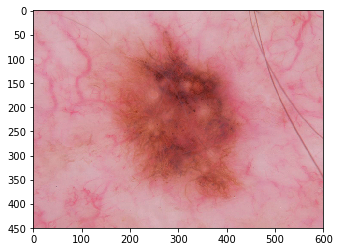

In [167]:
img, label = dataset.__visualizeitem__(2200)
plt.imshow(img)
print(label)

## Convolutional networks

### simple neural network

In [168]:
class SimpleNet(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.fc = nn.Linear(in_features=1620000, out_features=num_classes)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool(output)

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.conv4(output)
        output = self.relu4(output)

        output = output.view(-1, 1620000)

        output = self.fc(output)

        return output

In [169]:
net = SimpleNet()
net.to(device)

SimpleNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (fc): Linear(in_features=1620000, out_features=7, bias=True)
)

In [170]:
# Feed a batch of images from the training data to test the network
with torch.no_grad():
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    images = images.to(device)
    print('Shape of the input tensor:', images.shape)

    y = net(images)
    assert y.shape == torch.Size([1, 7]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

Shape of the input tensor: torch.Size([1, 3, 450, 600])
The shapes seem to be ok.


In [171]:
# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [174]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [176]:
n_epochs = 2

In [177]:
# Let us train the network for 10 epochs (one epoch is one pass though the training data)
# The loss should go down during training
net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Transfer to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    # Print accuracy after every epoch
    accuracy = compute_accuracy(net, testloader)
    print('Accuracy of the network on the test images: %.3f' % accuracy)

    if skip_training:
        break

print('Finished Training')

[1,   200] loss: 1.780
[1,   400] loss: 1.384
[1,   600] loss: 1.208
[1,   800] loss: 1.098
[1,  1000] loss: 1.250
[1,  1200] loss: 1.117
[1,  1400] loss: 1.213
[1,  1600] loss: 1.133
[1,  1800] loss: 1.182
[1,  2000] loss: 1.211
[1,  2200] loss: 1.090
[1,  2400] loss: 1.196
[1,  2600] loss: 1.136
[1,  2800] loss: 1.134
[1,  3000] loss: 1.286
[1,  3200] loss: 1.103
[1,  3400] loss: 1.163
[1,  3600] loss: 1.156
[1,  3800] loss: 1.216
[1,  4000] loss: 1.097
[1,  4200] loss: 1.169
[1,  4400] loss: 1.109
[1,  4600] loss: 1.018
[1,  4800] loss: 1.292
[1,  5000] loss: 1.274
[1,  5200] loss: 1.111
[1,  5400] loss: 1.163
[1,  5600] loss: 1.081
[1,  5800] loss: 1.101
[1,  6000] loss: 1.101
[1,  6200] loss: 1.113
[1,  6400] loss: 1.108
[1,  6600] loss: 1.210
[1,  6800] loss: 1.156
[1,  7000] loss: 1.076
[1,  7200] loss: 1.155
[1,  7400] loss: 1.097
[1,  7600] loss: 1.090
[1,  7800] loss: 1.100
[1,  8000] loss: 1.031
Accuracy of the network on the test images: 0.669
[2,   200] loss: 1.128
[2,   4

In [98]:
        inputs = inputs.to(device)
        labels = labels.to(device)

### Saved model

In [ ]:
# Save the network to a file, submit this file together with your notebook
filename = '4_simple_conv_net.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net = Net()
    net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net.to(device)
    print('Model loaded from %s' % filename)

In [179]:
# Let us look at the confusion matrix computed for the test set
import sklearn.metrics as skmetrics

def confusion_matrix(net, testloader):
    net.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs.data, 1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    true_labels = np.hstack(true_labels)
    predictions = np.hstack(predictions)

    return skmetrics.confusion_matrix(true_labels, predictions)

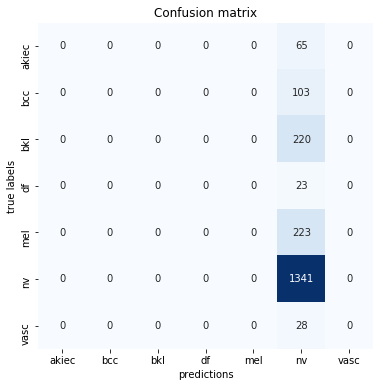

In [187]:
import seaborn as sns

c_matrix = confusion_matrix(net, testloader)
plt.figure(figsize=(6, 6))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=False)
plt.xlabel('predictions')
plt.ylabel('true labels')

In [100]:
labels

tensor([1], device='cuda:0', dtype=torch.int8)

In [55]:
#img = Image.open(r'data/images/ISIC_0027419')
#img = Image.open(open("/data/images/ISIC_0027419", 'rb'))
img = Image.open('data/images/ISIC_0027419.jpg')

In [59]:
#img = Image.open(r'data/images/ISIC_0027419')

FileNotFoundError: [Errno 2] No such file or directory: 'data/images/ISIC_0027419'